# INTELIGENCIA ARTIFICIAL (1INF24\)
Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)

# ALGORITMOS DE REGRESION




#REGRESIÓN LINEAL

In [ ]:
# Cargar librerias y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion

In [ ]:
import tensorflow

In [ ]:
# Carga la libreria Keras (de Tensorflow) para crear redes neuronales
from tensorflow import keras

In [ ]:
# Carga capas de Keras para crear redes neuronales MLP
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

In [ ]:
# Version de tensorflow y keras
print(tensorflow.__version__)

2.18.0


### Carga dataset MNIST

In [ ]:
# Importamos la información de nuestra csv
df = pd.read_csv('dataset_climatico_huancayo.csv', sep = ',')
df = df.set_index('fecha') # Usar la fecha como índice facilita las operaciones temporales
df.sort_index(inplace=True)

In [ ]:
df.dtypes

,0
temperature_2m_max,float64
temperature_2m_min,float64
temperature_2m_mean,float64
precipitation_sum,float64
relative_humidity_2m_mean,int64
wind_speed_10m_max,float64
soil_temperature_0_to_7cm_mean,float64
soil_temperature_7_to_28cm_mean,float64
soil_temperature_28_to_100cm_mean,float64
soil_moisture_0_to_7cm_mean,float64


In [ ]:
df.isnull().sum()

,0
temperature_2m_max,0
temperature_2m_min,0
temperature_2m_mean,0
precipitation_sum,0
relative_humidity_2m_mean,0
wind_speed_10m_max,0
soil_temperature_0_to_7cm_mean,0
soil_temperature_7_to_28cm_mean,0
soil_temperature_28_to_100cm_mean,0
soil_moisture_0_to_7cm_mean,0


In [ ]:
#No existen valores nulos dentro del set

In [ ]:
df.shape[0]

16071

In [ ]:
#df.loc[df.soil_moisture_0_to_7cm_mean < 0.30].shape[0]/df.shape[0]

In [ ]:
#Borramos esas filas
#df = df[df.soil_moisture_0_to_7cm_mean >= 0.30]

In [ ]:
#df.loc[df.relative_humidity_2m_mean < 65].shape[0]/df.shape[0]
#df = df[df.relative_humidity_2m_mean >= 65]

In [ ]:
#df = df[df.wind_speed_10m_max <= 15]
#df.loc[df.wind_speed_10m_max > 15].shape[0]/df.shape[0]

In [ ]:
print("--- 2. Cargando y Preprocesando Datos ---")

# Carga del dataset y parseo de fechas
df = pd.read_csv('dataset_climatico_huancayo.csv', parse_dates=['fecha'])
df = df.set_index('fecha') # Usar la fecha como índice facilita las operaciones temporales
df.sort_index(inplace=True)

--- 2. Cargando y Preprocesando Datos ---


In [ ]:
# 2.1 Ingeniería de Características
# ---------------------------------
print("Creando características temporales, de desfase y de ventana móvil...")

# Características cíclicas para capturar la estacionalidad
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month

df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Características de desfase (Lag Features) para las variables más importantes
for lag in range(1, 4): # Usaremos los 3 días anteriores
    df[f'temp_mean_lag_{lag}'] = df['temperature_2m_mean'].shift(lag)
    df[f'precip_lag_{lag}'] = df['precipitation_sum'].shift(lag)
    df[f'humidity_lag_{lag}'] = df['relative_humidity_2m_mean'].shift(lag)

# Características de ventana móvil (Rolling Features) para suavizar
df['temp_rolling_mean_7d'] = df['temperature_2m_mean'].shift(1).rolling(window=7).mean()
df['temp_rolling_std_7d'] = df['temperature_2m_mean'].shift(1).rolling(window=7).std()

# Eliminar filas con NaN generadas por las nuevas características
df.dropna(inplace=True)

Creando características temporales, de desfase y de ventana móvil...


In [ ]:
# 2.2 Selección y Limpieza Final de Características
# ---------------------------------------------------
# Eliminamos columnas que no aportan o son redundantes
df = df.drop(columns=['temperature_2m_max', 'temperature_2m_min', 'day_of_year', 'month'])

# Las temperaturas y humedades del suelo están altamente correlacionadas.
# Eliminamos dos de ellas para reducir multicolinealidad.
df = df.drop(columns=['soil_temperature_7_to_28cm_mean', 'soil_moisture_7_to_28cm_mean'])

print(f"Dataset listo con {df.shape[1]} características y {df.shape[0]} filas.")
print("Primeras filas del DataFrame preprocesado:")
print(df.head())
print("-" * 50)

Dataset listo con 23 características y 16064 filas.
Primeras filas del DataFrame preprocesado:
            temperature_2m_mean  precipitation_sum  relative_humidity_2m_mean  \
fecha                                                                           
1980-01-08                  5.5                7.8                         86   
1980-01-09                  5.1                9.6                         87   
1980-01-10                  5.1               11.4                         82   
1980-01-11                  5.6                1.1                         78   
1980-01-12                  4.7                1.9                         82   

            wind_speed_10m_max  soil_temperature_0_to_7cm_mean  \
fecha                                                            
1980-01-08                 8.5                            11.0   
1980-01-09                 6.8                            11.1   
1980-01-10                 8.0                            10.9   
1980-01

In [ ]:
df.shape[0]

16064

In [ ]:
# Dividimos los datos de forma cronológica, una práctica estándar para series temporales.
train_df = df[df.index.year <= 2019]
valid_df = df[df.index.year >= 2020]



In [ ]:
#Separar x e y para cada conjunto
x_train = train_df.drop(columns=['temperature_2m_mean'])
y_train = train_df['temperature_2m_mean']

x_test = valid_df.drop(columns=['temperature_2m_mean'])
y_test = valid_df['temperature_2m_mean']

In [ ]:
df.head()

,temperature_2m_mean,precipitation_sum,relative_humidity_2m_mean,wind_speed_10m_max,soil_temperature_0_to_7cm_mean,soil_temperature_28_to_100cm_mean,soil_moisture_0_to_7cm_mean,soil_moisture_28_to_100cm_mean,day_sin,day_cos,...,precip_lag_1,humidity_lag_1,temp_mean_lag_2,precip_lag_2,humidity_lag_2,temp_mean_lag_3,precip_lag_3,humidity_lag_3,temp_rolling_mean_7d,temp_rolling_std_7d
fecha,,,,,,,,,,,,,,,,,,,,,
1980-01-08,5.5,7.8,86,8.5,11.0,10.9,0.42,0.41,0.14,0.99,...,7.9,86.0,5.6,5.4,85.0,5.4,5.9,85.0,5.33,0.17
1980-01-09,5.1,9.6,87,6.8,11.1,10.9,0.41,0.41,0.15,0.99,...,7.8,86.0,5.5,7.9,86.0,5.6,5.4,85.0,5.37,0.17
1980-01-10,5.1,11.4,82,8.0,10.9,10.9,0.42,0.42,0.17,0.99,...,9.6,87.0,5.5,7.8,86.0,5.5,7.9,86.0,5.36,0.19
1980-01-11,5.6,1.1,78,12.1,11.6,10.9,0.41,0.42,0.19,0.98,...,11.4,82.0,5.1,9.6,87.0,5.5,7.8,86.0,5.34,0.21
1980-01-12,4.7,1.9,82,8.4,11.0,10.9,0.41,0.42,0.20,0.98,...,1.1,78.0,5.1,11.4,82.0,5.1,9.6,87.0,5.40,0.22


In [ ]:
# Cargar libreriras y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]  #por defecto las figuras se displayan 10 pulgadas de ancho y 8 de alto

from sklearn.linear_model import LinearRegression   # para modelos de regresion lineal
from sklearn.linear_model import Ridge   # Ridge regression
from sklearn.linear_model import Lasso   # Lasso regression
from sklearn.linear_model import ElasticNet  # ElasticNet regression
from sklearn.neighbors import KNeighborsRegressor  # Knn regression
from sklearn.tree import DecisionTreeRegressor   # Decision Trees regression
from sklearn.svm import SVR  # Support Vector regression

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import mean_squared_error, mean_absolute_error   # para manejar metricas de desempeño
from sklearn.metrics import explained_variance_score  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import r2_score  # para manejar matrices de confusion

In [ ]:
seed = 7   # semilla para el generador aleatorio (para reproductibilidad)

print('Training: %d ejemplos. Test: %d ejemplos' % (len(y_train), len(y_test)))

Training: 14603 ejemplos. Test: 1461 ejemplos


In [ ]:
# Definimos el pool de algoritmos de ML a evaluar
algos = []
algos.append(('LinearReg', LinearRegression( )))
algos.append(('Ridge', Ridge( )))
algos.append(('Lasso', Lasso()))
algos.append(('ElasticNet', ElasticNet()))
algos.append(('KNN3', KNeighborsRegressor( n_neighbors=3 ) ))
algos.append(('KNN', KNeighborsRegressor( n_neighbors=5 ) ))
algos.append(('RegTrees', DecisionTreeRegressor( )))

In [ ]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold( n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada algoritmo
for algoname, algo in algos:
    cv_results = cross_val_score(algo, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')  #r2 neg_mean_squared_error
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LinearReg: -0.13029961916742214 (0.0058868079691149775)
Ridge: -0.13030968328578496 (0.005914941729475696)
Lasso: -0.8805251627057741 (0.035042498783014395)
ElasticNet: -0.49910734102025656 (0.02044264806847604)
KNN3: -0.43629507718176386 (0.013934909791047088)
KNN: -0.4064469269125107 (0.013070612079896678)
RegTrees: -0.2819867279870233 (0.009424649102968453)


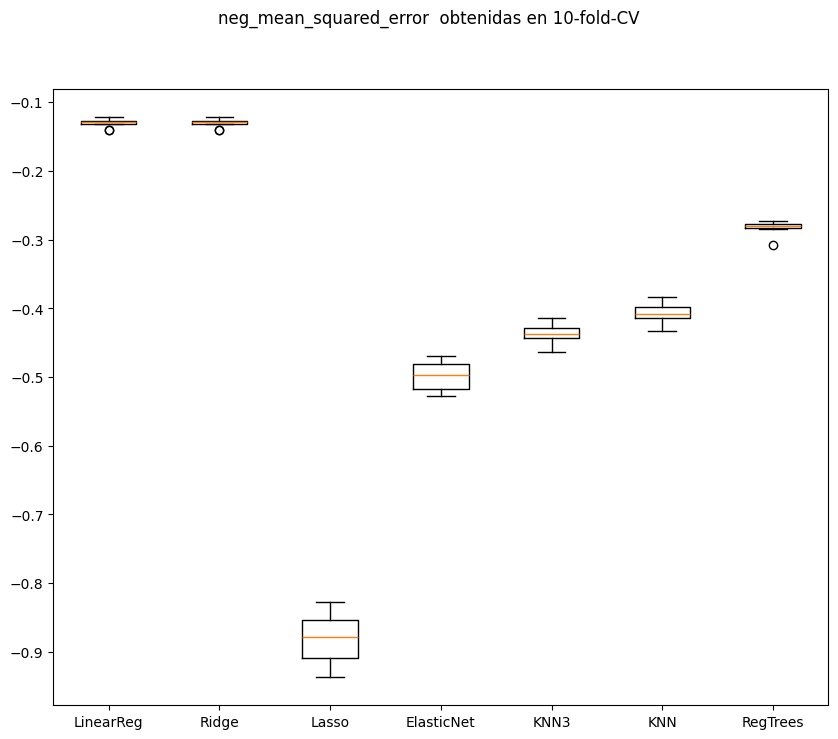

In [ ]:
# Muestra graficamente los resultados de neg_mean_absolute_error  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure()
fig.suptitle('neg_mean_squared_error  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# Reentrena modelo de regresion LinearRegression con todos los datos de entrenamiento y lo prueba en el conjunto de test
model = LinearRegression( )
model.fit(x_train, y_train)

# predice el target en el conjunto de test
y_predicted = model.predict(x_test)
print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:", explained_variance_score(y_test, y_predicted))
print("R2 score:", r2_score(y_test, y_predicted))

Mean squared error: 0.22984728712961744
Mean absolute error: 0.381253581639922
Explained variance score: 0.7617099777199293
R2 score: 0.7427827561172025


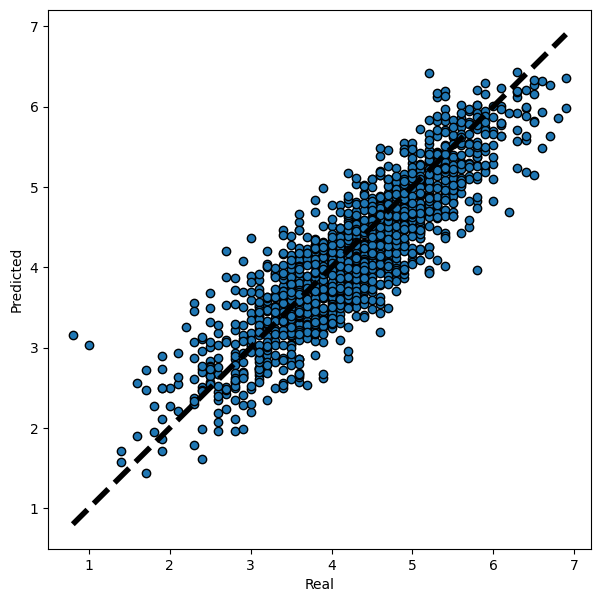

In [ ]:
fig, ax = plt.subplots( figsize=[7,7])
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
# obtiene los coeficientes del modelo
model.coef_

array([ 3.41088368e-03, -3.68923556e-02, -1.21528656e-02,  4.97823766e-01,
       -3.94578981e-01,  1.44183168e+00,  3.89229077e-01,  1.81487992e-01,
        5.78081098e-04,  7.49766360e-03, -6.94870499e-03,  4.44207772e-01,
       -3.23688365e-03,  1.71115660e-02, -3.01844472e-02,  4.10169124e-03,
       -1.87722427e-03,  1.27500169e-02,  2.63809294e-03, -1.22957975e-03,
        2.66203444e-01,  4.19974883e-02])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

# Definimos el pool de pipleines de ML (escalador + algoritmo de ML) a evaluar
pipelines = []
pipelines.append(('pipLinearReg', make_pipeline(MinMaxScaler(), LinearRegression())))
pipelines.append(('pipRidge', make_pipeline(StandardScaler(), Ridge())))
pipelines.append(('pipLasso', make_pipeline(StandardScaler(), Lasso())))
pipelines.append(('pipElasticNet', make_pipeline(StandardScaler(), ElasticNet())))
pipelines.append(('pipKNN', make_pipeline(StandardScaler(), KNeighborsRegressor( ))))
pipelines.append(('pipRegTrees', make_pipeline(StandardScaler(), DecisionTreeRegressor())))

In [ ]:
# Evaluamos cada pipeline de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada pipeline en crosvalidacion
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

pipLinearReg: -0.13029961916742216 (0.00588680796911498)
pipRidge: -0.13029929380076555 (0.005886961099048438)
pipLasso: -1.1504531433203382 (0.03727871058295289)
pipElasticNet: -0.5915216300992053 (0.020456927444656416)
pipKNN: -0.21092215746392506 (0.009012947131700583)
pipRegTrees: -0.2777263682221785 (0.010950331814352886)


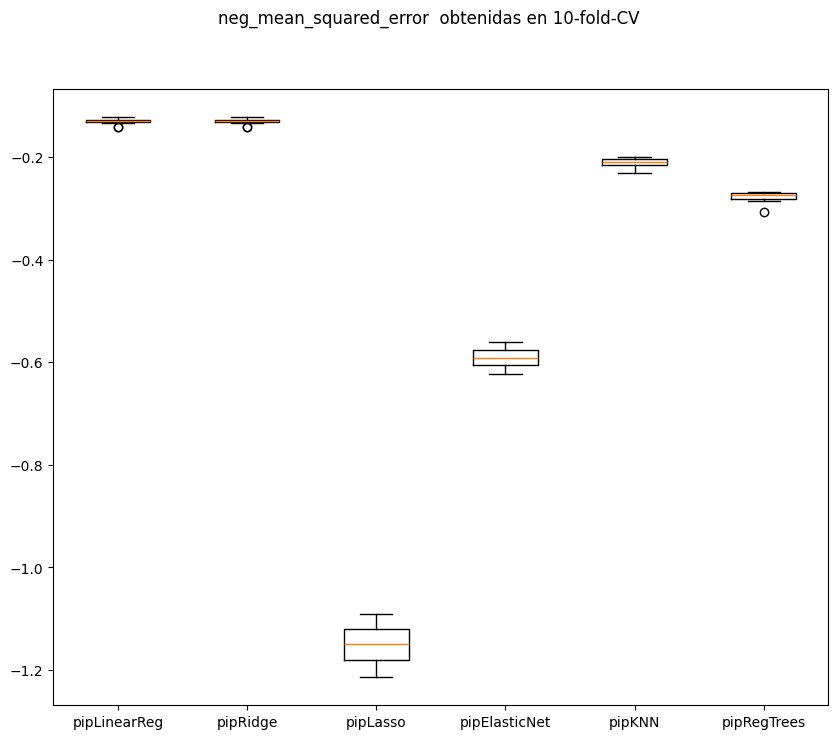

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los pipelines evaluados
fig = plt.figure()
fig.suptitle('neg_mean_squared_error  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Mean squared error: 0.22984728712961727
Mean absolute error: 0.3812535816399216
Explained variance score: 0.7617099777199298
R2 score: 0.7427827561172026


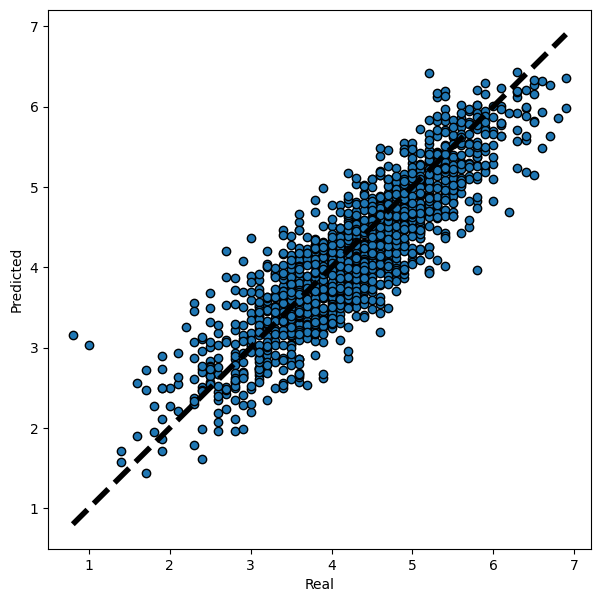

In [ ]:
# Reentrena el pipeline con con todos los datos de entrenamiento y lo prueba en el conjunto de validación
pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline.fit(x_train, y_train)

# predice el target en el conjunto de validacion
y_predicted = pipeline.predict(x_test)
print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:", explained_variance_score(y_test, y_predicted))
print("R2 score:", r2_score(y_test, y_predicted))

# Plotea los valores reales vs los predichos en el conjunto de validacion
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

# Random Forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Crear el modelo de Random Forest para regresión
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Entrenar el modelo con los datos de entrenamiento
print("\nEntrenando el modelo Random Forest...")
rf_model.fit(x_train, y_train)
print("Entrenamiento finalizado.")


Entrenando el modelo Random Forest...
Entrenamiento finalizado.


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_model.predict(x_test)

# Evaluar el rendimiento del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Resultados de la Evaluación ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

print(f"\nInterpretación:")
print(f"El modelo se desvía en promedio {mae:.2f} grados Celsius de la temperatura real.")
print(f"El R² de {r2:.2f} indica que el modelo explica aproximadamente el {r2*100:.0f}% de la variabilidad en la temperatura media.")


--- Resultados de la Evaluación ---
Mean Absolute Error (MAE): 0.43
Mean Squared Error (MSE): 0.31
R-squared (R²): 0.65

Interpretación:
El modelo se desvía en promedio 0.43 grados Celsius de la temperatura real.
El R² de 0.65 indica que el modelo explica aproximadamente el 65% de la variabilidad en la temperatura media.



--- Importancia de las Características ---
                              feature  importance
11                    temp_mean_lag_1    6.58e-01
3      soil_temperature_0_to_7cm_mean    1.81e-01
1           relative_humidity_2m_mean    2.22e-02
7                             day_sin    1.40e-02
4   soil_temperature_28_to_100cm_mean    1.25e-02
6      soil_moisture_28_to_100cm_mean    1.13e-02
20               temp_rolling_mean_7d    9.68e-03
2                  wind_speed_10m_max    8.15e-03
8                             day_cos    7.94e-03
13                     humidity_lag_1    7.81e-03
0                   precipitation_sum    7.53e-03
5         soil_moisture_0_to_7cm_mean    7.20e-03
21                temp_rolling_std_7d    7.10e-03
12                       precip_lag_1    5.97e-03
16                     humidity_lag_2    5.90e-03
17                    temp_mean_lag_3    5.88e-03
15                       precip_lag_2    5.56e-03
18                       precip_lag_3    5.50e-03
9     

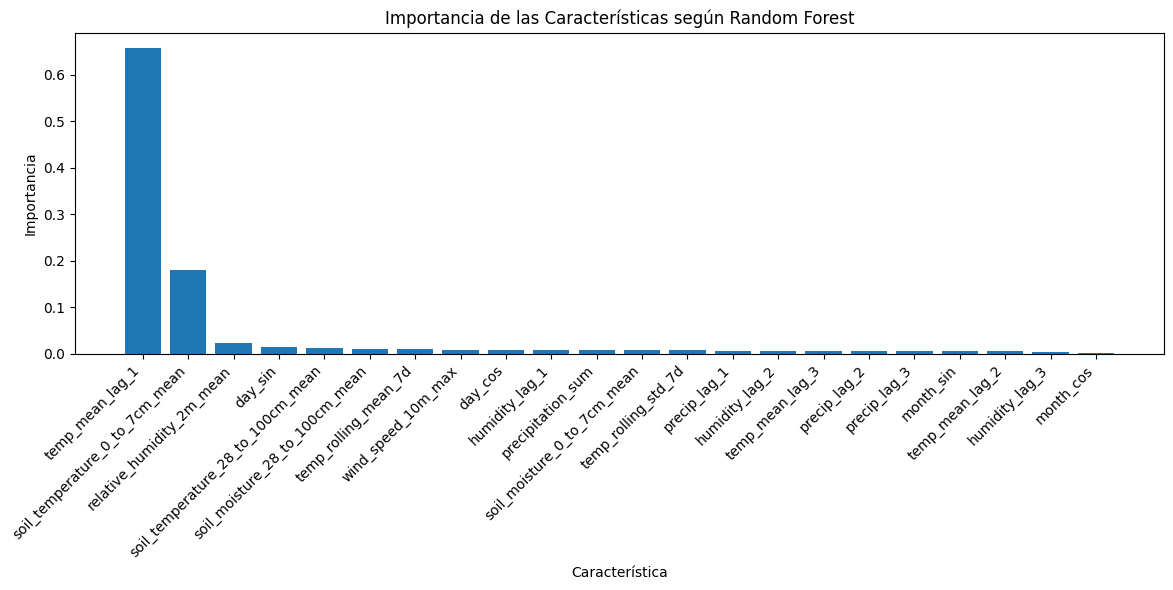

In [ ]:
# Obtener la importancia de las características
importances = rf_model.feature_importances_
# SOLUCIÓN: Usar las columnas de X_train, no del X original.
feature_names = x_train.columns

# Crear un DataFrame para una mejor visualización
# Ahora ambos arrays tienen la misma longitud y el código funcionará.
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\n--- Importancia de las Características ---")
print(feature_importance_df)

# Visualizar la importancia de las características
plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Importancia de las Características según Random Forest')
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

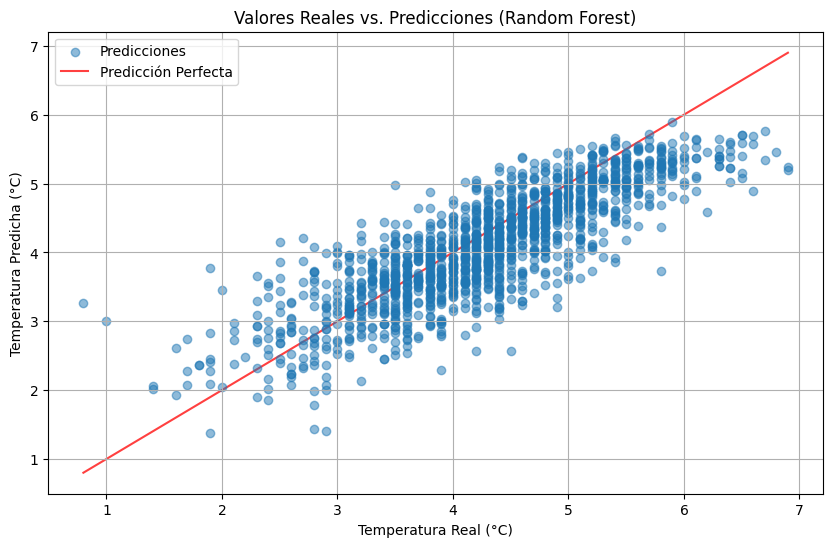

In [ ]:
# Gráfico de dispersión de valores reales vs. predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicciones')
plt.title('Valores Reales vs. Predicciones (Random Forest)')
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.grid(True)

# Añadir la línea de predicción perfecta
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r-', alpha=0.75, zorder=0, label='Predicción Perfecta')
plt.legend()
plt.show()

In [ ]:
y_pred = rf_model.predict(x_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("\n--- Resultados de la Evaluación del Modelo ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f}°C")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinación (R²): {r2:.2f}")


--- Resultados de la Evaluación del Modelo ---
Error Absoluto Medio (MAE): 0.43°C
Error Cuadrático Medio (MSE): 0.31
Coeficiente de Determinación (R²): 0.65


# Red neuronal MLP para clasificacion de imagenes de digitos (dataset MNIST)

In [ ]:
print("--- 1. Cargando Librerías ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f"TensorFlow Version: {tensorflow.__version__}")

--- 1. Cargando Librerías ---
TensorFlow Version: 2.18.0


In [ ]:
# Version de tensorflow y keras
print(tensorflow.__version__)

2.18.0


In [ ]:
print("--- 2. Cargando y Preprocesando Datos ---")

# Carga del dataset y parseo de fechas
df = pd.read_csv('dataset_climatico_huancayo.csv', parse_dates=['fecha'])
df = df.set_index('fecha') # Usar la fecha como índice facilita las operaciones temporales
df.sort_index(inplace=True)

--- 2. Cargando y Preprocesando Datos ---


In [ ]:
# 2.1 Ingeniería de Características
# ---------------------------------
print("Creando características temporales, de desfase y de ventana móvil...")

# Características cíclicas para capturar la estacionalidad
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month

df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Características de desfase (Lag Features) para las variables más importantes
for lag in range(1, 4): # Usaremos los 3 días anteriores
    df[f'temp_mean_lag_{lag}'] = df['temperature_2m_mean'].shift(lag)
    df[f'precip_lag_{lag}'] = df['precipitation_sum'].shift(lag)
    df[f'humidity_lag_{lag}'] = df['relative_humidity_2m_mean'].shift(lag)

# Características de ventana móvil (Rolling Features) para suavizar
df['temp_rolling_mean_7d'] = df['temperature_2m_mean'].shift(1).rolling(window=7).mean()
df['temp_rolling_std_7d'] = df['temperature_2m_mean'].shift(1).rolling(window=7).std()

# Eliminar filas con NaN generadas por las nuevas características
df.dropna(inplace=True)

Creando características temporales, de desfase y de ventana móvil...


In [ ]:
# 2.2 Selección y Limpieza Final de Características
# ---------------------------------------------------
# Eliminamos columnas que no aportan o son redundantes
df = df.drop(columns=['temperature_2m_max', 'temperature_2m_min', 'day_of_year', 'month'])

# Las temperaturas y humedades del suelo están altamente correlacionadas.
# Eliminamos dos de ellas para reducir multicolinealidad.
df = df.drop(columns=['soil_temperature_7_to_28cm_mean', 'soil_moisture_7_to_28cm_mean'])

print(f"Dataset listo con {df.shape[1]} características y {df.shape[0]} filas.")
print("Primeras filas del DataFrame preprocesado:")
print(df.head())
print("-" * 50)

Dataset listo con 23 características y 16064 filas.
Primeras filas del DataFrame preprocesado:
            temperature_2m_mean  precipitation_sum  relative_humidity_2m_mean  \
fecha                                                                           
1980-01-08                  5.5                7.8                         86   
1980-01-09                  5.1                9.6                         87   
1980-01-10                  5.1               11.4                         82   
1980-01-11                  5.6                1.1                         78   
1980-01-12                  4.7                1.9                         82   

            wind_speed_10m_max  soil_temperature_0_to_7cm_mean  \
fecha                                                            
1980-01-08                 8.5                            11.0   
1980-01-09                 6.8                            11.1   
1980-01-10                 8.0                            10.9   
1980-01

In [ ]:
# =============================================================================
# 3. División de Datos (Entrenamiento y Validación)
# =============================================================================
print("--- 3. Dividiendo Datos ---")

# Dividimos los datos de forma cronológica, una práctica estándar para series temporales.
train_df = df[df.index.year <= 2019]
valid_df = df[df.index.year >= 2020]

# Separar características (X) y variable objetivo (y)
X_train = train_df.drop(columns=['temperature_2m_mean'])
y_train = train_df['temperature_2m_mean']

X_valid = valid_df.drop(columns=['temperature_2m_mean'])
y_valid = valid_df['temperature_2m_mean']

print(f'Train:      X={X_train.shape}, y={y_train.shape}')
print(f'Validación: X={X_valid.shape}, y={y_valid.shape}')
print("-" * 50)

--- 3. Dividiendo Datos ---
Train:      X=(14603, 22), y=(14603,)
Validación: X=(1461, 22), y=(1461,)
--------------------------------------------------


In [ ]:
# =============================================================================
# 4. Escalamiento de Datos
# =============================================================================
print("--- 4. Escalando los Datos ---")
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_valid_scaled = scaler_X.transform(X_valid)

--- 4. Escalando los Datos ---


In [ ]:

# =============================================================================
# 5. Construcción y Entrenamiento del Modelo MLP Mejorado
# =============================================================================
print("--- 5. Construyendo y Entrenando el Modelo ---")

def define_improved_mlp(input_dim):
    """
    Define una arquitectura MLP mejorada con capas de Dropout para regularización.
    """
    modelo = Sequential()

    # Capa de entrada y primera capa oculta
    modelo.add(Dense(128, activation="relu", input_shape=(input_dim,)))
    modelo.add(Dropout(0.2)) # Apaga el 20% de las neuronas para evitar sobreajuste

    # Segunda capa oculta
    modelo.add(Dense(64, activation="relu"))
    modelo.add(Dropout(0.2))

    # Tercera capa oculta
    modelo.add(Dense(32, activation="relu"))

    # Capa de salida (1 neurona para regresión)
    modelo.add(Dense(1))

    # Compilación del modelo
    modelo.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return modelo

--- 5. Construyendo y Entrenando el Modelo ---


In [ ]:
# Definimos el modelo final
modelo_final = define_improved_mlp(input_dim=X_train_scaled.shape[1])
modelo_final.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks para un entrenamiento más inteligente
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Más paciencia antes de detener
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce el LR en un 80%
    patience=5,
    min_lr=0.00001
)

# Entrenamiento del modelo
history = modelo_final.fit(
    X_train_scaled, y_train,
    epochs=150,  # Aumentamos las épocas, EarlyStopping se encargará de parar
    batch_size=32,
    verbose=1,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[early_stopping, reduce_lr]
)
print("-" * 50)

Epoch 1/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.5474 - mae: 1.1094 - val_loss: 0.5133 - val_mae: 0.5852 - learning_rate: 0.0010
Epoch 2/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4121 - mae: 0.5024 - val_loss: 0.4873 - val_mae: 0.5846 - learning_rate: 0.0010
Epoch 3/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2919 - mae: 0.4263 - val_loss: 0.3750 - val_mae: 0.5004 - learning_rate: 0.0010
Epoch 4/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2423 - mae: 0.3873 - val_loss: 0.4108 - val_mae: 0.5321 - learning_rate: 0.0010
Epoch 5/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2010 - mae: 0.3541 - val_loss: 0.3534 - val_mae: 0.4858 - learning_rate: 0.0010
Epoch 6/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1905 - mae: 0.3421 - val_loss: 0.2984 - val_mae: 0.4432 - learning_rate: 0.0010
Epoch 7/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1740 - mae: 0.3261 - val_loss: 0.3441 - val_mae: 0.4780 - learning_rate: 0.0010

In [ ]:
# =============================================================================
# 6. Análisis de Resultados y Errores
# =============================================================================
print("--- 6. Evaluando el Modelo Final ---")

# Predecir en el conjunto de validación
y_pred = modelo_final.predict(X_valid_scaled)

--- 6. Evaluando el Modelo Final ---
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Calcular métricas de rendimiento
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

print("Métricas de rendimiento en el conjunto de validación:")
print(f"Error Absoluto Medio (MAE):   {mae:.3f} °C")
print(f"Error Cuadrático Medio (MSE):   {mse:.3f} °C²")
print(f"Raíz del ECM (RMSE):          {rmse:.3f} °C")
print(f"Coeficiente de Determinación (R²): {r2:.3f}")

Métricas de rendimiento en el conjunto de validación:
Error Absoluto Medio (MAE):   0.427 °C
Error Cuadrático Medio (MSE):   0.285 °C²
Raíz del ECM (RMSE):          0.533 °C
Coeficiente de Determinación (R²): 0.682


In [ ]:
# 6.1 Visualización del Entrenamiento
# -----------------------------------
print("Generando curvas de aprendizaje...")
plt.figure(figsize=(12, 5))

Generando curvas de aprendizaje...


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

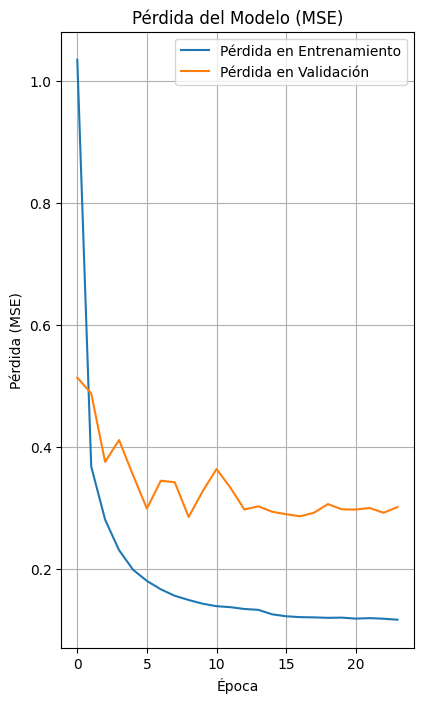

In [ ]:
# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.title('Pérdida del Modelo (MSE)')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)

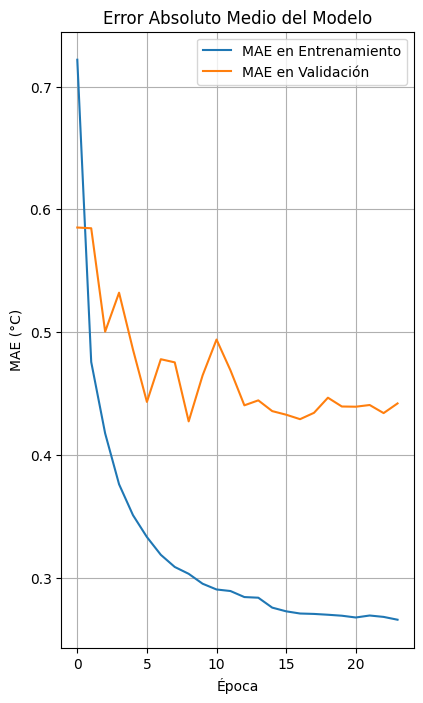

In [ ]:
# Gráfico de Error Absoluto Medio (MAE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE en Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE en Validación')
plt.title('Error Absoluto Medio del Modelo')
plt.xlabel('Época')
plt.ylabel('MAE (°C)')
plt.legend()
plt.grid(True)

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

Generando gráficos de análisis de error...


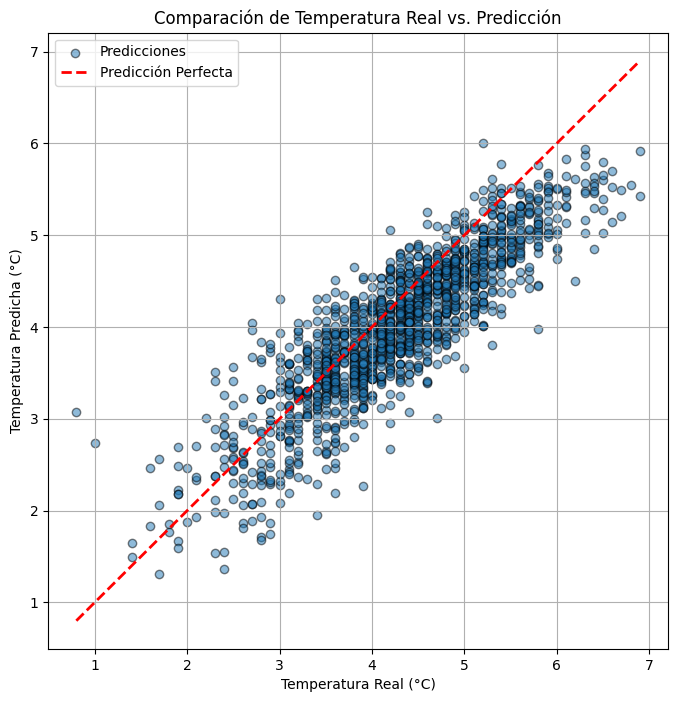

In [ ]:
# 6.2 Visualización de Resultados de Predicción
# -----------------------------------------------
print("Generando gráficos de análisis de error...")

# Gráfico 1: Real vs. Predicción
plt.figure(figsize=(8, 8))
plt.scatter(y_valid, y_pred, alpha=0.5, edgecolors='k', label='Predicciones')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', lw=2, label='Predicción Perfecta')
plt.xlabel("Temperatura Real (°C)")
plt.ylabel("Temperatura Predicha (°C)")
plt.title("Comparación de Temperatura Real vs. Predicción")
plt.legend()
plt.grid(True)
plt.show()

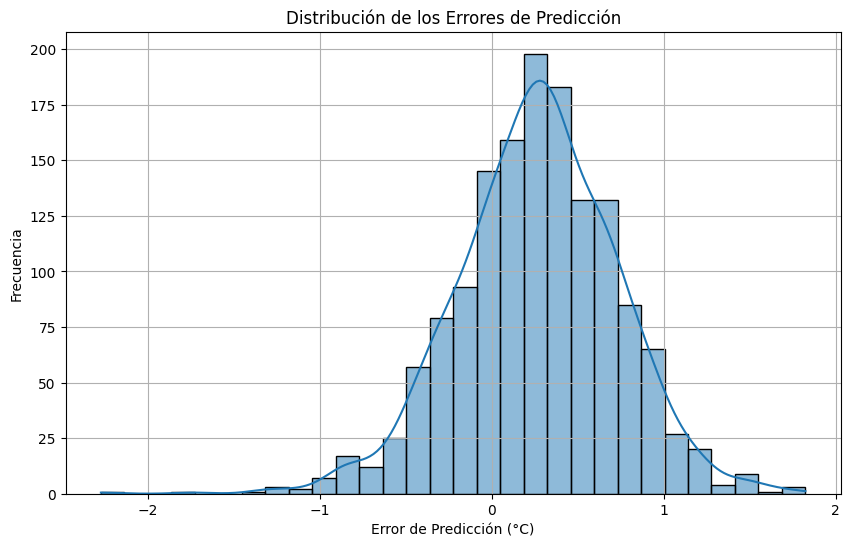

In [ ]:
# Gráfico 2: Distribución de los Errores
errores = y_valid - y_pred.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(errores, bins=30, kde=True)
plt.xlabel("Error de Predicción (°C)")
plt.ylabel("Frecuencia")
plt.title("Distribución de los Errores de Predicción")
plt.grid(True)
plt.show()